# Imports

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import sys
import os
sys.path.append(os.path.abspath("../"))

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from notebooks.ntb_utils import *
from actpatt_dag.analysis.decision_tree import DecisionTree
from actpatt_dag.torch_dataset.indexed_dataset import *
from actpatt_dag.torch_dataset.vision_datasets import *

# Data

In [20]:
layers_idx = [f"l{i}" for i in range(5)]
print("Layers indeces:", layers_idx)

Layers indeces: ['l0', 'l1', 'l2', 'l3', 'l4']


### Load collected data

In [21]:
data = load_pickle("../data/MNIST_stats.pkl")
data.keys()

dict_keys(['forgetting_events', 'training_loss', 'training_accuracy', 'train_apdf', 'test_apdf'])

### Load train dataframe

In [22]:
train_df = data['train_apdf']

# Add column for correct/wrong instances 
train_df['correct'] = np.where(train_df.label == train_df.output, 1, 0)

train_df.head()

,instance,label,output,l0,l1,l2,l3,l4,correct
0,31221,2,2,10101101011110010010110010110110,00100000101100101111010100011111,11101001011010111111001001011101,11011101100011000111101110001110,01011001100000001011111100000111,1
1,23380,0,0,00011000011110010011100001110100,01101001101100011111011100011010,11110001010110111111101101101111,01011100100110011111100101000000,11111101010011100111101010010101,1
2,24648,4,4,00101111111111010100100001011011,00110000110100011110111110100110,01110011000011111101101000011111,01011101101111011001110101011100,00110100100011000001010000011111,1
3,45824,9,9,00101011111110010010000001111010,00110000110110011110111110000111,11110011001010110101101001011111,01011111101111011011110101011100,01010100011011000011111010011101,1
4,58215,2,2,10111101001100010101010000100110,00110000101110111111010100011110,11101011111010011110101001010100,11011101100011000111101110011110,01011001100000001011111100000111,1


### Load test dataframe

In [23]:
test_df = data['test_apdf']

# Add column for correct/wrong instances 
test_df['correct'] = np.where(test_df.label == test_df.output, 1, 0)

test_df.head()

,instance,label,output,l0,l1,l2,l3,l4,correct
0,213,3,3,10001110011101010010000111011010,00100000111100011010011110010111,11111011001110110110111101111010,11011111000111001111100101011101,01000001111001001011111110001111,1
1,9637,7,7,00101010111101010001100001010110,00101000101100011010011110000110,10110011001110110110101101111111,11011110100111001111100101000000,11000101111010000011111010011001,1
2,2535,6,6,00011110101110010000100000010010,00111000101100101110111000111010,11010010010010111111101101011111,01010101101001011111111110011110,00111001100011100010110000011111,1
3,5543,8,8,00101001001111010010010011111100,00111000100100111110011100011111,11110011011011111010101101011101,11011111101011010111110001011100,01110101100011100010111000001111,1
4,1896,5,5,00011000011100011010000011111000,01101000111110011111011100010111,11110001011010111100101101101111,01011111101110011111110101010100,01110101011011100010111000001101,1


### Load Forgetting Events Dictionary

In [24]:
# Dictionary with epochs for learning/forgetting events
forget = data['forgetting_events']

keys = list(forget.keys())
forget_df = pd.DataFrame(keys, columns=['instance'])

# Compute number of forgetting events for each instance
forget_df['forget_events'] = forget_df.apply(lambda x: len(forget[x.instance]['forget-events']), axis=1)

forget_df.head()

,instance,forget_events
0,40254,0
1,50629,0
2,28765,0
3,16739,0
4,16879,0


# APDF - clustering

In [25]:
train_dec = DecisionTree(train_df, layers_idx, split_col="output")

In [26]:
test_dec = DecisionTree(test_df, layers_idx, split_col="output")

In [27]:
train_clusters_df = train_dec.clust_df
test_clusters_df = test_dec.clust_df
train_clusters_df.head()

,instance,clust_size,clust_id
0,14753,1,0
1,45408,1,1
2,34237,1,2
3,203,1,3
4,19590,1,4


# Data Viz

In [28]:
sns.set(style="ticks", font_scale=1.5)

### Count Actiation Patterns

In [29]:
patt_count = []
df_label = ['train', 'test']
for i, df in enumerate([train_df, test_df]):
    for l in layers_idx:
        # Unique activation patterns
        unique = np.unique(df[l])
        patt_count.append([df_label[i], l, len(unique)])

patt_count_df = pd.DataFrame(patt_count, columns=['dataset', 'layer', '# patterns'])

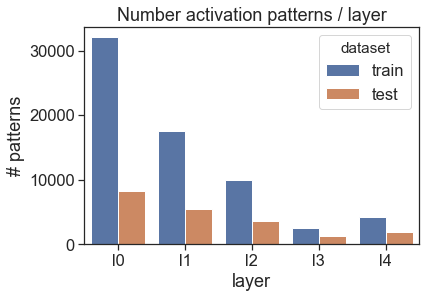

In [30]:
sns.barplot('layer', '# patterns', 'dataset', data=patt_count_df)
plt.title('Number activation patterns / layer');

### Forgetting Events Distribution

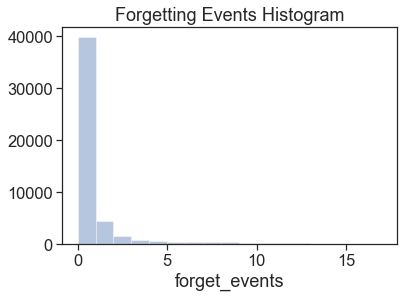

In [32]:
max_forget = np.max(forget_df['forget_events'])
sns.distplot(forget_df['forget_events'], kde=False, bins=list(range(max_forget)))
plt.title("Forgetting Events Histogram");

### APDF Cluster Size Distribution

In [33]:
train_clusters_df['dataset'] = 'train'
test_clusters_df['dataset'] = 'test'

both_clust_df = train_clusters_df.append(test_clusters_df)
both_clust_df['clust_size'] = pd.to_numeric(both_clust_df['clust_size'])

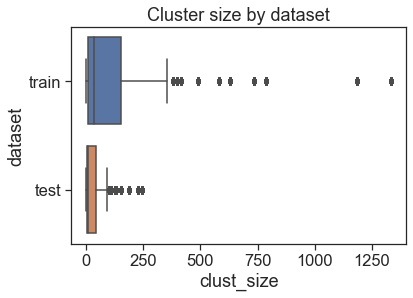

In [34]:
sns.boxplot('clust_size', 'dataset', data=both_clust_df)
plt.title('Cluster size by dataset');